In [1]:
import keras
from keras import regularizers
import numpy as np
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import RMSprop, Adam
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential, Input
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D
from keras.layers import LSTM, Bidirectional, Activation, CuDNNLSTM, Layer
from keras.callbacks import ModelCheckpoint
from keras import initializers, regularizers, constraints, optimizers, layers

import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
%matplotlib inline

Using TensorFlow backend.


In [2]:
import keras.backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [17]:
tqdm.monitor_interval = 0
#hyperparamter
DATA_DIR = "../data/"
output_dir = '../data/lstm_attn/'

#data
test_size = 0.1
validation_size = 0.1
random_state = 12345

#Training 
epochs = 20
batch_size = 128

#vector-space embedding
n_dim = 64
n_unique_words = 10000
max_length = 100
pad_type = trunc_type = 'pre' # 'pre' or 'post'
drop_embed = 0.25
trainable = False

#lstm architecture 
n_lstm = 64
drop_lstm = 0.1
kernel_reg_lstm = 0.000014
activity_reg_lstm = 0.000012

#fully connected layer 
n_fc = 64
kernel_reg_fc = 0.000013
drop_fc = 0.1

#optimizer 
learning_rate = 0.0007


In [4]:
# load the data
with open('../data/data.pkl','rb') as f:
    data = pickle.load(f)
with open('../data/labels.pkl','rb') as f:
    labels = pickle.load(f)

In [5]:
# with open('../data/data.pkl','wb') as f:
#     pickle.dump(data,f)
# with open('../data/labels.pkl','wb') as f:
#     pickle.dump(labels,f)

In [6]:
len(data)

51915

In [7]:
one_hot = MultiLabelBinarizer()
labels = one_hot.fit_transform(labels)
len(labels[0])

62

In [8]:
data = np.array(data)
labels = np.array(labels)


In [9]:
train_x,test_x, train_y, test_y = train_test_split(data, labels, test_size=test_size, random_state=random_state)

In [10]:
len(train_x), len(train_y), len(test_x), len(test_y)

(46723, 46723, 5192, 5192)

In [11]:
train_y = [x for x in train_y.transpose()]
test_y = [x for x in test_y.transpose()]

In [12]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [13]:
tok_1 = Tokenizer(num_words=n_unique_words)
tok_1.fit_on_texts(train_x)                                
sequences = tok_1.texts_to_sequences(train_x)
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_length, padding=pad_type, truncating=trunc_type)

In [14]:
EMBEDDING_FILE = '../data/embeddings/glove.840B.300d/glove.840B.300d.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

In [15]:
word_index = tok_1.word_index
nb_words = min(n_unique_words, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in tqdm(word_index.items()):
    if i >= n_unique_words: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

100%|██████████| 93515/93515 [00:00<00:00, 1606757.27it/s]


In [16]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim


In [18]:
def RNN_1():
    inputs = Input(name='inputs', shape=[max_length])
    layer = Embedding(n_unique_words, 
                      300, 
                      #input_length=max_length, 
                      weights=[embedding_matrix], 
                      trainable=trainable
                     )(inputs)  
    layer = SpatialDropout1D(drop_embed)(layer)
    layer = Bidirectional(CuDNNLSTM(n_lstm, 
#                                kernel_regularizer=regularizers.l2(kernel_reg_lstm),
#                                activity_regularizer=regularizers.l1(activity_reg_lstm),
                            return_sequences=True)
                         )(layer)
    
    layer = Attention(max_length)(layer)
    layer_lst=[]
    sigmoid_lst=[]
    for i in range(len(train_y)):
        fc1 = Dense(n_fc,
                    name='FC_1_'+str(i),
                    activation="relu"
                   )(layer)
        fc1 = Dropout(drop_fc)(fc1)
        fc2 = Dense(1,
                    name='FC_2_'+str(i)
                   )(fc1)
        sigmoid_lst.append(Activation('sigmoid')(fc2))

    model = Model(inputs=inputs, outputs=sigmoid_lst)
    return model
model = RNN_1()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     3000000     inputs[0][0]                     
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 100, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 100, 128)     187392      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
attention_

In [19]:
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=learning_rate),metrics=['accuracy'])
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5", save_best_only=True)
history = model.fit(sequences_matrix,
          train_y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=validation_size, 
          callbacks=[modelcheckpoint])

Train on 42050 samples, validate on 4673 samples
Epoch 1/20
42050/42050 [==============================] - 67s 2ms/step - loss: 6.8462 - activation_1_loss: 0.0168 - activation_2_loss: 0.1079 - activation_3_loss: 0.0982 - activation_4_loss: 0.0489 - activation_5_loss: 0.0223 - activation_6_loss: 0.0177 - activation_7_loss: 0.1209 - activation_8_loss: 0.1341 - activation_9_loss: 0.0189 - activation_10_loss: 0.1202 - activation_11_loss: 0.3206 - activation_12_loss: 0.0184 - activation_13_loss: 0.3815 - activation_14_loss: 0.0903 - activation_15_loss: 0.1046 - activation_16_loss: 0.1743 - activation_17_loss: 0.4450 - activation_18_loss: 0.1488 - activation_19_loss: 0.1021 - activation_20_loss: 0.0170 - activation_21_loss: 0.0995 - activation_22_loss: 0.0917 - activation_23_loss: 0.0536 - activation_24_loss: 0.0670 - activation_25_loss: 0.0214 - activation_26_loss: 0.1666 - activation_27_loss: 0.1520 - activation_28_loss: 0.0298 - activation_29_loss: 0.0317 - activation_30_loss: 0.0724 - ac

  256/42050 [..............................] - ETA: 48s - loss: 5.4727 - activation_1_loss: 6.9845e-04 - activation_2_loss: 0.1257 - activation_3_loss: 0.1552 - activation_4_loss: 0.0241 - activation_5_loss: 5.1132e-04 - activation_6_loss: 3.4331e-04 - activation_7_loss: 0.0956 - activation_8_loss: 0.0979 - activation_9_loss: 4.9967e-04 - activation_10_loss: 0.1075 - activation_11_loss: 0.2715 - activation_12_loss: 6.2767e-04 - activation_13_loss: 0.3883 - activation_14_loss: 0.0758 - activation_15_loss: 0.0986 - activation_16_loss: 0.2108 - activation_17_loss: 0.2261 - activation_18_loss: 0.1050 - activation_19_loss: 0.1103 - activation_20_loss: 1.4862e-04 - activation_21_loss: 0.0810 - activation_22_loss: 0.0672 - activation_23_loss: 0.0626 - activation_24_loss: 0.0642 - activation_25_loss: 7.2351e-04 - activation_26_loss: 0.1632 - activation_27_loss: 0.1368 - activation_28_loss: 0.0018 - activation_29_loss: 0.0013 - activation_30_loss: 0.0251 - activation_31_loss: 0.0268 - activatio

42050/42050 [==============================] - 45s 1ms/step - loss: 5.0348 - activation_1_loss: 0.0026 - activation_2_loss: 0.0882 - activation_3_loss: 0.0747 - activation_4_loss: 0.0288 - activation_5_loss: 0.0034 - activation_6_loss: 0.0024 - activation_7_loss: 0.0996 - activation_8_loss: 0.1143 - activation_9_loss: 0.0041 - activation_10_loss: 0.1037 - activation_11_loss: 0.2719 - activation_12_loss: 0.0023 - activation_13_loss: 0.3561 - activation_14_loss: 0.0668 - activation_15_loss: 0.0860 - activation_16_loss: 0.1598 - activation_17_loss: 0.2341 - activation_18_loss: 0.1053 - activation_19_loss: 0.0826 - activation_20_loss: 2.8204e-04 - activation_21_loss: 0.0736 - activation_22_loss: 0.0749 - activation_23_loss: 0.0369 - activation_24_loss: 0.0444 - activation_25_loss: 0.0064 - activation_26_loss: 0.1134 - activation_27_loss: 0.1190 - activation_28_loss: 0.0123 - activation_29_loss: 0.0103 - activation_30_loss: 0.0514 - activation_31_loss: 0.0214 - activation_32_loss: 0.1728 - 

  256/42050 [..............................] - ETA: 47s - loss: 5.0804 - activation_1_loss: 4.9086e-04 - activation_2_loss: 0.1394 - activation_3_loss: 0.0465 - activation_4_loss: 0.0030 - activation_5_loss: 2.9268e-04 - activation_6_loss: 1.6296e-04 - activation_7_loss: 0.0963 - activation_8_loss: 0.0970 - activation_9_loss: 3.8832e-04 - activation_10_loss: 0.1142 - activation_11_loss: 0.3455 - activation_12_loss: 2.1265e-04 - activation_13_loss: 0.3227 - activation_14_loss: 0.1626 - activation_15_loss: 0.0544 - activation_16_loss: 0.1721 - activation_17_loss: 0.1968 - activation_18_loss: 0.0919 - activation_19_loss: 0.0960 - activation_20_loss: 6.2378e-05 - activation_21_loss: 0.0644 - activation_22_loss: 0.0815 - activation_23_loss: 0.0272 - activation_24_loss: 0.0421 - activation_25_loss: 8.4656e-04 - activation_26_loss: 0.0910 - activation_27_loss: 0.0455 - activation_28_loss: 0.0025 - activation_29_loss: 0.0011 - activation_30_loss: 0.0810 - activation_31_loss: 0.0031 - activatio

42050/42050 [==============================] - 45s 1ms/step - loss: 4.5942 - activation_1_loss: 0.0027 - activation_2_loss: 0.0854 - activation_3_loss: 0.0718 - activation_4_loss: 0.0282 - activation_5_loss: 0.0033 - activation_6_loss: 0.0022 - activation_7_loss: 0.0859 - activation_8_loss: 0.1090 - activation_9_loss: 0.0040 - activation_10_loss: 0.0865 - activation_11_loss: 0.2544 - activation_12_loss: 0.0022 - activation_13_loss: 0.3417 - activation_14_loss: 0.0635 - activation_15_loss: 0.0811 - activation_16_loss: 0.1533 - activation_17_loss: 0.2150 - activation_18_loss: 0.0866 - activation_19_loss: 0.0799 - activation_20_loss: 3.1625e-04 - activation_21_loss: 0.0611 - activation_22_loss: 0.0641 - activation_23_loss: 0.0355 - activation_24_loss: 0.0415 - activation_25_loss: 0.0063 - activation_26_loss: 0.0886 - activation_27_loss: 0.1031 - activation_28_loss: 0.0118 - activation_29_loss: 0.0100 - activation_30_loss: 0.0486 - activation_31_loss: 0.0201 - activation_32_loss: 0.1323 - 

  256/42050 [..............................] - ETA: 57s - loss: 4.2968 - activation_1_loss: 4.0934e-04 - activation_2_loss: 0.1268 - activation_3_loss: 0.0945 - activation_4_loss: 0.0235 - activation_5_loss: 3.6627e-04 - activation_6_loss: 1.5658e-04 - activation_7_loss: 0.0774 - activation_8_loss: 0.0544 - activation_9_loss: 6.4488e-04 - activation_10_loss: 0.0581 - activation_11_loss: 0.2408 - activation_12_loss: 2.6326e-04 - activation_13_loss: 0.3325 - activation_14_loss: 0.0652 - activation_15_loss: 0.0711 - activation_16_loss: 0.1770 - activation_17_loss: 0.1794 - activation_18_loss: 0.1120 - activation_19_loss: 0.0635 - activation_20_loss: 5.2523e-05 - activation_21_loss: 0.0806 - activation_22_loss: 0.0668 - activation_23_loss: 0.0050 - activation_24_loss: 0.0203 - activation_25_loss: 0.0011 - activation_26_loss: 0.0852 - activation_27_loss: 0.0955 - activation_28_loss: 0.0014 - activation_29_loss: 0.0326 - activation_30_loss: 0.0427 - activation_31_loss: 0.0038 - activation_32

42050/42050 [==============================] - 46s 1ms/step - loss: 4.3353 - activation_1_loss: 0.0026 - activation_2_loss: 0.0835 - activation_3_loss: 0.0707 - activation_4_loss: 0.0274 - activation_5_loss: 0.0033 - activation_6_loss: 0.0022 - activation_7_loss: 0.0706 - activation_8_loss: 0.1020 - activation_9_loss: 0.0038 - activation_10_loss: 0.0720 - activation_11_loss: 0.2455 - activation_12_loss: 0.0021 - activation_13_loss: 0.3378 - activation_14_loss: 0.0576 - activation_15_loss: 0.0761 - activation_16_loss: 0.1478 - activation_17_loss: 0.2072 - activation_18_loss: 0.0803 - activation_19_loss: 0.0794 - activation_20_loss: 2.5680e-04 - activation_21_loss: 0.0523 - activation_22_loss: 0.0486 - activation_23_loss: 0.0340 - activation_24_loss: 0.0372 - activation_25_loss: 0.0062 - activation_26_loss: 0.0809 - activation_27_loss: 0.0885 - activation_28_loss: 0.0116 - activation_29_loss: 0.0096 - activation_30_loss: 0.0463 - activation_31_loss: 0.0199 - activation_32_loss: 0.1119 - 

  256/42050 [..............................] - ETA: 46s - loss: 4.3193 - activation_1_loss: 3.5979e-04 - activation_2_loss: 0.1243 - activation_3_loss: 0.0658 - activation_4_loss: 0.0632 - activation_5_loss: 4.7616e-04 - activation_6_loss: 1.1503e-04 - activation_7_loss: 0.0864 - activation_8_loss: 0.0844 - activation_9_loss: 6.3330e-04 - activation_10_loss: 0.0606 - activation_11_loss: 0.2038 - activation_12_loss: 2.5427e-04 - activation_13_loss: 0.3710 - activation_14_loss: 0.0297 - activation_15_loss: 0.0563 - activation_16_loss: 0.1318 - activation_17_loss: 0.2043 - activation_18_loss: 0.0551 - activation_19_loss: 0.1449 - activation_20_loss: 5.1838e-05 - activation_21_loss: 0.0410 - activation_22_loss: 0.0414 - activation_23_loss: 0.0301 - activation_24_loss: 0.0055 - activation_25_loss: 0.0013 - activation_26_loss: 0.0923 - activation_27_loss: 0.0751 - activation_28_loss: 0.0016 - activation_29_loss: 0.0018 - activation_30_loss: 0.0393 - activation_31_loss: 0.0458 - activation_32

42050/42050 [==============================] - 45s 1ms/step - loss: 4.1844 - activation_1_loss: 0.0025 - activation_2_loss: 0.0818 - activation_3_loss: 0.0694 - activation_4_loss: 0.0268 - activation_5_loss: 0.0034 - activation_6_loss: 0.0020 - activation_7_loss: 0.0595 - activation_8_loss: 0.0965 - activation_9_loss: 0.0036 - activation_10_loss: 0.0641 - activation_11_loss: 0.2408 - activation_12_loss: 0.0021 - activation_13_loss: 0.3374 - activation_14_loss: 0.0525 - activation_15_loss: 0.0736 - activation_16_loss: 0.1444 - activation_17_loss: 0.2001 - activation_18_loss: 0.0779 - activation_19_loss: 0.0777 - activation_20_loss: 2.8703e-04 - activation_21_loss: 0.0466 - activation_22_loss: 0.0394 - activation_23_loss: 0.0330 - activation_24_loss: 0.0345 - activation_25_loss: 0.0061 - activation_26_loss: 0.0778 - activation_27_loss: 0.0841 - activation_28_loss: 0.0111 - activation_29_loss: 0.0097 - activation_30_loss: 0.0443 - activation_31_loss: 0.0195 - activation_32_loss: 0.1035 - 

  256/42050 [..............................] - ETA: 48s - loss: 4.5045 - activation_1_loss: 3.5002e-04 - activation_2_loss: 0.0515 - activation_3_loss: 0.1128 - activation_4_loss: 0.0345 - activation_5_loss: 4.6034e-04 - activation_6_loss: 2.5577e-04 - activation_7_loss: 0.0887 - activation_8_loss: 0.0588 - activation_9_loss: 4.4194e-04 - activation_10_loss: 0.0675 - activation_11_loss: 0.2562 - activation_12_loss: 3.0870e-04 - activation_13_loss: 0.3077 - activation_14_loss: 0.0264 - activation_15_loss: 0.0890 - activation_16_loss: 0.1852 - activation_17_loss: 0.1712 - activation_18_loss: 0.1520 - activation_19_loss: 0.0922 - activation_20_loss: 3.3993e-05 - activation_21_loss: 0.0761 - activation_22_loss: 0.0196 - activation_23_loss: 0.1250 - activation_24_loss: 0.1036 - activation_25_loss: 0.0262 - activation_26_loss: 0.1046 - activation_27_loss: 0.0600 - activation_28_loss: 0.0260 - activation_29_loss: 0.0015 - activation_30_loss: 0.0603 - activation_31_loss: 0.0260 - activation_32

42050/42050 [==============================] - 45s 1ms/step - loss: 4.0925 - activation_1_loss: 0.0026 - activation_2_loss: 0.0808 - activation_3_loss: 0.0687 - activation_4_loss: 0.0266 - activation_5_loss: 0.0033 - activation_6_loss: 0.0020 - activation_7_loss: 0.0538 - activation_8_loss: 0.0940 - activation_9_loss: 0.0035 - activation_10_loss: 0.0625 - activation_11_loss: 0.2374 - activation_12_loss: 0.0020 - activation_13_loss: 0.3340 - activation_14_loss: 0.0477 - activation_15_loss: 0.0722 - activation_16_loss: 0.1419 - activation_17_loss: 0.1955 - activation_18_loss: 0.0760 - activation_19_loss: 0.0763 - activation_20_loss: 2.9513e-04 - activation_21_loss: 0.0434 - activation_22_loss: 0.0343 - activation_23_loss: 0.0320 - activation_24_loss: 0.0332 - activation_25_loss: 0.0060 - activation_26_loss: 0.0748 - activation_27_loss: 0.0816 - activation_28_loss: 0.0107 - activation_29_loss: 0.0095 - activation_30_loss: 0.0424 - activation_31_loss: 0.0193 - activation_32_loss: 0.0990 - 

  256/42050 [..............................] - ETA: 46s - loss: 3.9178 - activation_1_loss: 2.4472e-04 - activation_2_loss: 0.0690 - activation_3_loss: 0.0700 - activation_4_loss: 0.0238 - activation_5_loss: 2.8601e-04 - activation_6_loss: 2.1617e-04 - activation_7_loss: 0.0118 - activation_8_loss: 0.0944 - activation_9_loss: 4.8178e-04 - activation_10_loss: 0.0476 - activation_11_loss: 0.2152 - activation_12_loss: 4.7392e-05 - activation_13_loss: 0.3461 - activation_14_loss: 0.0107 - activation_15_loss: 0.0224 - activation_16_loss: 0.0796 - activation_17_loss: 0.2156 - activation_18_loss: 0.0523 - activation_19_loss: 0.0871 - activation_20_loss: 5.5818e-05 - activation_21_loss: 0.0357 - activation_22_loss: 0.0202 - activation_23_loss: 0.0184 - activation_24_loss: 0.0298 - activation_25_loss: 0.0302 - activation_26_loss: 0.0575 - activation_27_loss: 0.0735 - activation_28_loss: 0.0223 - activation_29_loss: 0.0016 - activation_30_loss: 0.0737 - activation_31_loss: 0.0286 - activation_32

42050/42050 [==============================] - 46s 1ms/step - loss: 4.0211 - activation_1_loss: 0.0026 - activation_2_loss: 0.0808 - activation_3_loss: 0.0684 - activation_4_loss: 0.0263 - activation_5_loss: 0.0032 - activation_6_loss: 0.0019 - activation_7_loss: 0.0494 - activation_8_loss: 0.0928 - activation_9_loss: 0.0034 - activation_10_loss: 0.0598 - activation_11_loss: 0.2345 - activation_12_loss: 0.0022 - activation_13_loss: 0.3324 - activation_14_loss: 0.0447 - activation_15_loss: 0.0712 - activation_16_loss: 0.1399 - activation_17_loss: 0.1922 - activation_18_loss: 0.0740 - activation_19_loss: 0.0759 - activation_20_loss: 2.9274e-04 - activation_21_loss: 0.0419 - activation_22_loss: 0.0321 - activation_23_loss: 0.0309 - activation_24_loss: 0.0319 - activation_25_loss: 0.0057 - activation_26_loss: 0.0732 - activation_27_loss: 0.0793 - activation_28_loss: 0.0104 - activation_29_loss: 0.0095 - activation_30_loss: 0.0411 - activation_31_loss: 0.0189 - activation_32_loss: 0.0962 - 

  256/42050 [..............................] - ETA: 46s - loss: 4.1121 - activation_1_loss: 4.1589e-04 - activation_2_loss: 0.0866 - activation_3_loss: 0.0805 - activation_4_loss: 0.0317 - activation_5_loss: 7.6929e-04 - activation_6_loss: 5.0968e-04 - activation_7_loss: 0.0518 - activation_8_loss: 0.0536 - activation_9_loss: 0.0281 - activation_10_loss: 0.0752 - activation_11_loss: 0.1987 - activation_12_loss: 2.0667e-04 - activation_13_loss: 0.3102 - activation_14_loss: 0.0134 - activation_15_loss: 0.1199 - activation_16_loss: 0.1377 - activation_17_loss: 0.1995 - activation_18_loss: 0.0766 - activation_19_loss: 0.0762 - activation_20_loss: 3.3017e-05 - activation_21_loss: 0.0606 - activation_22_loss: 0.0134 - activation_23_loss: 0.0034 - activation_24_loss: 0.0770 - activation_25_loss: 0.0194 - activation_26_loss: 0.0488 - activation_27_loss: 0.0750 - activation_28_loss: 0.0203 - activation_29_loss: 0.0019 - activation_30_loss: 0.0292 - activation_31_loss: 0.0405 - activation_32_los

42050/42050 [==============================] - 46s 1ms/step - loss: 3.9610 - activation_1_loss: 0.0026 - activation_2_loss: 0.0806 - activation_3_loss: 0.0672 - activation_4_loss: 0.0260 - activation_5_loss: 0.0033 - activation_6_loss: 0.0019 - activation_7_loss: 0.0467 - activation_8_loss: 0.0908 - activation_9_loss: 0.0033 - activation_10_loss: 0.0585 - activation_11_loss: 0.2312 - activation_12_loss: 0.0020 - activation_13_loss: 0.3299 - activation_14_loss: 0.0416 - activation_15_loss: 0.0704 - activation_16_loss: 0.1386 - activation_17_loss: 0.1889 - activation_18_loss: 0.0730 - activation_19_loss: 0.0746 - activation_20_loss: 2.7678e-04 - activation_21_loss: 0.0407 - activation_22_loss: 0.0302 - activation_23_loss: 0.0294 - activation_24_loss: 0.0306 - activation_25_loss: 0.0059 - activation_26_loss: 0.0719 - activation_27_loss: 0.0773 - activation_28_loss: 0.0103 - activation_29_loss: 0.0092 - activation_30_loss: 0.0400 - activation_31_loss: 0.0189 - activation_32_loss: 0.0943 - 

  256/42050 [..............................] - ETA: 59s - loss: 4.0272 - activation_1_loss: 2.3127e-04 - activation_2_loss: 0.1052 - activation_3_loss: 0.0635 - activation_4_loss: 0.0414 - activation_5_loss: 6.0729e-04 - activation_6_loss: 3.3229e-04 - activation_7_loss: 0.0209 - activation_8_loss: 0.0603 - activation_9_loss: 3.0323e-04 - activation_10_loss: 0.0401 - activation_11_loss: 0.2398 - activation_12_loss: 2.8834e-04 - activation_13_loss: 0.2252 - activation_14_loss: 0.0924 - activation_15_loss: 0.0932 - activation_16_loss: 0.1270 - activation_17_loss: 0.2033 - activation_18_loss: 0.0816 - activation_19_loss: 0.0952 - activation_20_loss: 3.7016e-05 - activation_21_loss: 0.0265 - activation_22_loss: 0.0061 - activation_23_loss: 0.0159 - activation_24_loss: 0.0132 - activation_25_loss: 4.0213e-04 - activation_26_loss: 0.1090 - activation_27_loss: 0.0848 - activation_28_loss: 9.2209e-04 - activation_29_loss: 0.0011 - activation_30_loss: 0.0628 - activation_31_loss: 0.0041 - activ

42050/42050 [==============================] - 45s 1ms/step - loss: 3.9090 - activation_1_loss: 0.0025 - activation_2_loss: 0.0794 - activation_3_loss: 0.0667 - activation_4_loss: 0.0254 - activation_5_loss: 0.0033 - activation_6_loss: 0.0017 - activation_7_loss: 0.0446 - activation_8_loss: 0.0897 - activation_9_loss: 0.0031 - activation_10_loss: 0.0570 - activation_11_loss: 0.2291 - activation_12_loss: 0.0020 - activation_13_loss: 0.3284 - activation_14_loss: 0.0405 - activation_15_loss: 0.0692 - activation_16_loss: 0.1375 - activation_17_loss: 0.1849 - activation_18_loss: 0.0721 - activation_19_loss: 0.0747 - activation_20_loss: 2.7069e-04 - activation_21_loss: 0.0400 - activation_22_loss: 0.0296 - activation_23_loss: 0.0282 - activation_24_loss: 0.0295 - activation_25_loss: 0.0058 - activation_26_loss: 0.0707 - activation_27_loss: 0.0767 - activation_28_loss: 0.0098 - activation_29_loss: 0.0089 - activation_30_loss: 0.0388 - activation_31_loss: 0.0188 - activation_32_loss: 0.0925 - 

  256/42050 [..............................] - ETA: 48s - loss: 4.0194 - activation_1_loss: 1.8896e-04 - activation_2_loss: 0.0556 - activation_3_loss: 0.0805 - activation_4_loss: 0.0666 - activation_5_loss: 4.4295e-04 - activation_6_loss: 0.0300 - activation_7_loss: 0.0379 - activation_8_loss: 0.0727 - activation_9_loss: 0.0162 - activation_10_loss: 0.0676 - activation_11_loss: 0.2140 - activation_12_loss: 2.9211e-04 - activation_13_loss: 0.4186 - activation_14_loss: 0.0140 - activation_15_loss: 0.0704 - activation_16_loss: 0.0920 - activation_17_loss: 0.1514 - activation_18_loss: 0.0679 - activation_19_loss: 0.0728 - activation_20_loss: 4.4952e-05 - activation_21_loss: 0.0135 - activation_22_loss: 0.0704 - activation_23_loss: 0.0563 - activation_24_loss: 0.0781 - activation_25_loss: 0.0010 - activation_26_loss: 0.0639 - activation_27_loss: 0.0605 - activation_28_loss: 0.0110 - activation_29_loss: 0.0026 - activation_30_loss: 0.0315 - activation_31_loss: 0.0382 - activation_32_loss: 0

42050/42050 [==============================] - 45s 1ms/step - loss: 3.8668 - activation_1_loss: 0.0024 - activation_2_loss: 0.0789 - activation_3_loss: 0.0655 - activation_4_loss: 0.0253 - activation_5_loss: 0.0032 - activation_6_loss: 0.0018 - activation_7_loss: 0.0435 - activation_8_loss: 0.0894 - activation_9_loss: 0.0032 - activation_10_loss: 0.0567 - activation_11_loss: 0.2267 - activation_12_loss: 0.0019 - activation_13_loss: 0.3261 - activation_14_loss: 0.0391 - activation_15_loss: 0.0681 - activation_16_loss: 0.1360 - activation_17_loss: 0.1831 - activation_18_loss: 0.0712 - activation_19_loss: 0.0733 - activation_20_loss: 2.2713e-04 - activation_21_loss: 0.0392 - activation_22_loss: 0.0281 - activation_23_loss: 0.0266 - activation_24_loss: 0.0289 - activation_25_loss: 0.0055 - activation_26_loss: 0.0695 - activation_27_loss: 0.0745 - activation_28_loss: 0.0097 - activation_29_loss: 0.0090 - activation_30_loss: 0.0379 - activation_31_loss: 0.0184 - activation_32_loss: 0.0912 - 

  256/42050 [..............................] - ETA: 46s - loss: 3.7913 - activation_1_loss: 2.6136e-04 - activation_2_loss: 0.0872 - activation_3_loss: 0.0881 - activation_4_loss: 0.0184 - activation_5_loss: 0.0222 - activation_6_loss: 1.8052e-04 - activation_7_loss: 0.0328 - activation_8_loss: 0.0855 - activation_9_loss: 3.1313e-04 - activation_10_loss: 0.0656 - activation_11_loss: 0.2588 - activation_12_loss: 7.7576e-05 - activation_13_loss: 0.2706 - activation_14_loss: 0.0206 - activation_15_loss: 0.0563 - activation_16_loss: 0.1000 - activation_17_loss: 0.2098 - activation_18_loss: 0.0391 - activation_19_loss: 0.1033 - activation_20_loss: 2.2153e-05 - activation_21_loss: 0.0353 - activation_22_loss: 0.0147 - activation_23_loss: 0.0326 - activation_24_loss: 0.0685 - activation_25_loss: 5.7653e-04 - activation_26_loss: 0.0455 - activation_27_loss: 0.0637 - activation_28_loss: 0.0126 - activation_29_loss: 0.0014 - activation_30_loss: 0.0567 - activation_31_loss: 0.0033 - activation_32

42050/42050 [==============================] - 45s 1ms/step - loss: 3.8288 - activation_1_loss: 0.0024 - activation_2_loss: 0.0783 - activation_3_loss: 0.0647 - activation_4_loss: 0.0250 - activation_5_loss: 0.0033 - activation_6_loss: 0.0015 - activation_7_loss: 0.0416 - activation_8_loss: 0.0878 - activation_9_loss: 0.0029 - activation_10_loss: 0.0546 - activation_11_loss: 0.2266 - activation_12_loss: 0.0021 - activation_13_loss: 0.3250 - activation_14_loss: 0.0374 - activation_15_loss: 0.0673 - activation_16_loss: 0.1351 - activation_17_loss: 0.1809 - activation_18_loss: 0.0701 - activation_19_loss: 0.0729 - activation_20_loss: 2.5394e-04 - activation_21_loss: 0.0384 - activation_22_loss: 0.0278 - activation_23_loss: 0.0257 - activation_24_loss: 0.0280 - activation_25_loss: 0.0055 - activation_26_loss: 0.0684 - activation_27_loss: 0.0735 - activation_28_loss: 0.0093 - activation_29_loss: 0.0086 - activation_30_loss: 0.0371 - activation_31_loss: 0.0187 - activation_32_loss: 0.0901 - 

  256/42050 [..............................] - ETA: 47s - loss: 3.6485 - activation_1_loss: 5.3377e-04 - activation_2_loss: 0.0599 - activation_3_loss: 0.0477 - activation_4_loss: 0.0253 - activation_5_loss: 5.8981e-04 - activation_6_loss: 2.0626e-04 - activation_7_loss: 0.0213 - activation_8_loss: 0.1164 - activation_9_loss: 0.0200 - activation_10_loss: 0.0484 - activation_11_loss: 0.2080 - activation_12_loss: 3.5916e-04 - activation_13_loss: 0.3149 - activation_14_loss: 0.0220 - activation_15_loss: 0.1058 - activation_16_loss: 0.1080 - activation_17_loss: 0.2029 - activation_18_loss: 0.0512 - activation_19_loss: 0.0471 - activation_20_loss: 2.1512e-05 - activation_21_loss: 0.0222 - activation_22_loss: 0.0211 - activation_23_loss: 0.0217 - activation_24_loss: 0.0184 - activation_25_loss: 0.0017 - activation_26_loss: 0.0912 - activation_27_loss: 0.0551 - activation_28_loss: 0.0017 - activation_29_loss: 0.0121 - activation_30_loss: 0.0399 - activation_31_loss: 0.0034 - activation_32_los

42050/42050 [==============================] - 45s 1ms/step - loss: 3.7915 - activation_1_loss: 0.0023 - activation_2_loss: 0.0777 - activation_3_loss: 0.0636 - activation_4_loss: 0.0247 - activation_5_loss: 0.0031 - activation_6_loss: 0.0016 - activation_7_loss: 0.0415 - activation_8_loss: 0.0871 - activation_9_loss: 0.0030 - activation_10_loss: 0.0539 - activation_11_loss: 0.2241 - activation_12_loss: 0.0019 - activation_13_loss: 0.3240 - activation_14_loss: 0.0372 - activation_15_loss: 0.0674 - activation_16_loss: 0.1339 - activation_17_loss: 0.1799 - activation_18_loss: 0.0685 - activation_19_loss: 0.0715 - activation_20_loss: 2.5765e-04 - activation_21_loss: 0.0377 - activation_22_loss: 0.0272 - activation_23_loss: 0.0244 - activation_24_loss: 0.0278 - activation_25_loss: 0.0055 - activation_26_loss: 0.0679 - activation_27_loss: 0.0725 - activation_28_loss: 0.0091 - activation_29_loss: 0.0087 - activation_30_loss: 0.0369 - activation_31_loss: 0.0182 - activation_32_loss: 0.0880 - 

  256/42050 [..............................] - ETA: 52s - loss: 3.9865 - activation_1_loss: 2.4881e-04 - activation_2_loss: 0.0400 - activation_3_loss: 0.0506 - activation_4_loss: 0.0269 - activation_5_loss: 3.2447e-04 - activation_6_loss: 9.7596e-05 - activation_7_loss: 0.0161 - activation_8_loss: 0.1082 - activation_9_loss: 7.5302e-04 - activation_10_loss: 0.0350 - activation_11_loss: 0.2534 - activation_12_loss: 3.9623e-04 - activation_13_loss: 0.2673 - activation_14_loss: 0.0391 - activation_15_loss: 0.0388 - activation_16_loss: 0.1985 - activation_17_loss: 0.2091 - activation_18_loss: 0.0788 - activation_19_loss: 0.0994 - activation_20_loss: 3.8342e-05 - activation_21_loss: 0.0568 - activation_22_loss: 0.0481 - activation_23_loss: 0.0387 - activation_24_loss: 0.0791 - activation_25_loss: 6.2903e-04 - activation_26_loss: 0.0772 - activation_27_loss: 0.0654 - activation_28_loss: 0.0018 - activation_29_loss: 0.0315 - activation_30_loss: 0.0436 - activation_31_loss: 0.0041 - activatio

42050/42050 [==============================] - 46s 1ms/step - loss: 3.7525 - activation_1_loss: 0.0024 - activation_2_loss: 0.0778 - activation_3_loss: 0.0628 - activation_4_loss: 0.0245 - activation_5_loss: 0.0031 - activation_6_loss: 0.0015 - activation_7_loss: 0.0407 - activation_8_loss: 0.0860 - activation_9_loss: 0.0031 - activation_10_loss: 0.0530 - activation_11_loss: 0.2222 - activation_12_loss: 0.0019 - activation_13_loss: 0.3233 - activation_14_loss: 0.0355 - activation_15_loss: 0.0667 - activation_16_loss: 0.1331 - activation_17_loss: 0.1772 - activation_18_loss: 0.0679 - activation_19_loss: 0.0712 - activation_20_loss: 2.3311e-04 - activation_21_loss: 0.0368 - activation_22_loss: 0.0265 - activation_23_loss: 0.0239 - activation_24_loss: 0.0264 - activation_25_loss: 0.0052 - activation_26_loss: 0.0666 - activation_27_loss: 0.0723 - activation_28_loss: 0.0089 - activation_29_loss: 0.0085 - activation_30_loss: 0.0359 - activation_31_loss: 0.0183 - activation_32_loss: 0.0860 - 

  256/42050 [..............................] - ETA: 43s - loss: 3.7654 - activation_1_loss: 1.6143e-04 - activation_2_loss: 0.0896 - activation_3_loss: 0.0718 - activation_4_loss: 0.0197 - activation_5_loss: 3.3274e-04 - activation_6_loss: 1.2704e-04 - activation_7_loss: 0.0166 - activation_8_loss: 0.0770 - activation_9_loss: 3.4304e-04 - activation_10_loss: 0.0449 - activation_11_loss: 0.2304 - activation_12_loss: 1.6112e-04 - activation_13_loss: 0.3251 - activation_14_loss: 0.0489 - activation_15_loss: 0.0356 - activation_16_loss: 0.1148 - activation_17_loss: 0.1569 - activation_18_loss: 0.0825 - activation_19_loss: 0.0689 - activation_20_loss: 1.4227e-05 - activation_21_loss: 0.0326 - activation_22_loss: 0.0339 - activation_23_loss: 0.0341 - activation_24_loss: 0.0078 - activation_25_loss: 0.0017 - activation_26_loss: 0.1017 - activation_27_loss: 0.0560 - activation_28_loss: 0.0023 - activation_29_loss: 0.0160 - activation_30_loss: 0.0414 - activation_31_loss: 0.0284 - activation_32

42050/42050 [==============================] - 45s 1ms/step - loss: 3.7219 - activation_1_loss: 0.0024 - activation_2_loss: 0.0777 - activation_3_loss: 0.0618 - activation_4_loss: 0.0243 - activation_5_loss: 0.0031 - activation_6_loss: 0.0014 - activation_7_loss: 0.0396 - activation_8_loss: 0.0856 - activation_9_loss: 0.0028 - activation_10_loss: 0.0521 - activation_11_loss: 0.2202 - activation_12_loss: 0.0018 - activation_13_loss: 0.3223 - activation_14_loss: 0.0348 - activation_15_loss: 0.0656 - activation_16_loss: 0.1325 - activation_17_loss: 0.1763 - activation_18_loss: 0.0666 - activation_19_loss: 0.0706 - activation_20_loss: 2.2235e-04 - activation_21_loss: 0.0370 - activation_22_loss: 0.0263 - activation_23_loss: 0.0231 - activation_24_loss: 0.0262 - activation_25_loss: 0.0051 - activation_26_loss: 0.0652 - activation_27_loss: 0.0709 - activation_28_loss: 0.0088 - activation_29_loss: 0.0081 - activation_30_loss: 0.0355 - activation_31_loss: 0.0180 - activation_32_loss: 0.0854 - 

  256/42050 [..............................] - ETA: 41s - loss: 4.0675 - activation_1_loss: 1.8928e-04 - activation_2_loss: 0.1332 - activation_3_loss: 0.0382 - activation_4_loss: 0.0402 - activation_5_loss: 2.9769e-04 - activation_6_loss: 6.9386e-04 - activation_7_loss: 0.0503 - activation_8_loss: 0.0928 - activation_9_loss: 2.3515e-04 - activation_10_loss: 0.0630 - activation_11_loss: 0.2176 - activation_12_loss: 2.2226e-04 - activation_13_loss: 0.3515 - activation_14_loss: 0.0298 - activation_15_loss: 0.0490 - activation_16_loss: 0.1720 - activation_17_loss: 0.1100 - activation_18_loss: 0.0521 - activation_19_loss: 0.0823 - activation_20_loss: 1.8649e-05 - activation_21_loss: 0.0452 - activation_22_loss: 0.0116 - activation_23_loss: 0.0091 - activation_24_loss: 0.0044 - activation_25_loss: 0.0208 - activation_26_loss: 0.0770 - activation_27_loss: 0.0781 - activation_28_loss: 0.0260 - activation_29_loss: 9.1095e-04 - activation_30_loss: 0.0522 - activation_31_loss: 0.0439 - activatio

42050/42050 [==============================] - 46s 1ms/step - loss: 3.6925 - activation_1_loss: 0.0024 - activation_2_loss: 0.0771 - activation_3_loss: 0.0610 - activation_4_loss: 0.0240 - activation_5_loss: 0.0031 - activation_6_loss: 0.0014 - activation_7_loss: 0.0389 - activation_8_loss: 0.0846 - activation_9_loss: 0.0029 - activation_10_loss: 0.0511 - activation_11_loss: 0.2194 - activation_12_loss: 0.0018 - activation_13_loss: 0.3207 - activation_14_loss: 0.0343 - activation_15_loss: 0.0654 - activation_16_loss: 0.1311 - activation_17_loss: 0.1742 - activation_18_loss: 0.0663 - activation_19_loss: 0.0703 - activation_20_loss: 2.2710e-04 - activation_21_loss: 0.0364 - activation_22_loss: 0.0260 - activation_23_loss: 0.0227 - activation_24_loss: 0.0254 - activation_25_loss: 0.0050 - activation_26_loss: 0.0644 - activation_27_loss: 0.0704 - activation_28_loss: 0.0087 - activation_29_loss: 0.0080 - activation_30_loss: 0.0354 - activation_31_loss: 0.0179 - activation_32_loss: 0.0849 - 

  256/42050 [..............................] - ETA: 51s - loss: 3.4875 - activation_1_loss: 3.1005e-04 - activation_2_loss: 0.0809 - activation_3_loss: 0.0735 - activation_4_loss: 0.0160 - activation_5_loss: 4.5677e-04 - activation_6_loss: 1.2791e-04 - activation_7_loss: 0.0385 - activation_8_loss: 0.0688 - activation_9_loss: 3.9182e-04 - activation_10_loss: 0.0265 - activation_11_loss: 0.1808 - activation_12_loss: 3.0092e-04 - activation_13_loss: 0.2440 - activation_14_loss: 0.0295 - activation_15_loss: 0.0726 - activation_16_loss: 0.1025 - activation_17_loss: 0.1757 - activation_18_loss: 0.0599 - activation_19_loss: 0.0782 - activation_20_loss: 3.4914e-05 - activation_21_loss: 0.0561 - activation_22_loss: 0.0080 - activation_23_loss: 0.0033 - activation_24_loss: 0.0335 - activation_25_loss: 2.9081e-04 - activation_26_loss: 0.0651 - activation_27_loss: 0.0624 - activation_28_loss: 7.2675e-04 - activation_29_loss: 7.8670e-04 - activation_30_loss: 0.0109 - activation_31_loss: 0.0188 - a

42050/42050 [==============================] - 45s 1ms/step - loss: 3.6637 - activation_1_loss: 0.0024 - activation_2_loss: 0.0764 - activation_3_loss: 0.0599 - activation_4_loss: 0.0234 - activation_5_loss: 0.0029 - activation_6_loss: 0.0012 - activation_7_loss: 0.0387 - activation_8_loss: 0.0848 - activation_9_loss: 0.0028 - activation_10_loss: 0.0504 - activation_11_loss: 0.2178 - activation_12_loss: 0.0018 - activation_13_loss: 0.3204 - activation_14_loss: 0.0336 - activation_15_loss: 0.0645 - activation_16_loss: 0.1309 - activation_17_loss: 0.1730 - activation_18_loss: 0.0656 - activation_19_loss: 0.0693 - activation_20_loss: 2.3304e-04 - activation_21_loss: 0.0364 - activation_22_loss: 0.0258 - activation_23_loss: 0.0224 - activation_24_loss: 0.0256 - activation_25_loss: 0.0049 - activation_26_loss: 0.0645 - activation_27_loss: 0.0688 - activation_28_loss: 0.0085 - activation_29_loss: 0.0081 - activation_30_loss: 0.0345 - activation_31_loss: 0.0179 - activation_32_loss: 0.0836 - 

  256/42050 [..............................] - ETA: 47s - loss: 3.5123 - activation_1_loss: 2.9814e-04 - activation_2_loss: 0.0916 - activation_3_loss: 0.0189 - activation_4_loss: 0.0214 - activation_5_loss: 0.0012 - activation_6_loss: 0.0115 - activation_7_loss: 0.0398 - activation_8_loss: 0.0892 - activation_9_loss: 4.5566e-04 - activation_10_loss: 0.0572 - activation_11_loss: 0.2208 - activation_12_loss: 3.3704e-04 - activation_13_loss: 0.2997 - activation_14_loss: 0.0340 - activation_15_loss: 0.0678 - activation_16_loss: 0.1171 - activation_17_loss: 0.1642 - activation_18_loss: 0.0563 - activation_19_loss: 0.0814 - activation_20_loss: 1.5527e-05 - activation_21_loss: 0.0472 - activation_22_loss: 0.0177 - activation_23_loss: 0.0269 - activation_24_loss: 0.0031 - activation_25_loss: 0.0011 - activation_26_loss: 0.0812 - activation_27_loss: 0.0919 - activation_28_loss: 0.0012 - activation_29_loss: 0.0014 - activation_30_loss: 0.0205 - activation_31_loss: 0.0287 - activation_32_loss: 0

42050/42050 [==============================] - 45s 1ms/step - loss: 3.6336 - activation_1_loss: 0.0023 - activation_2_loss: 0.0761 - activation_3_loss: 0.0587 - activation_4_loss: 0.0230 - activation_5_loss: 0.0030 - activation_6_loss: 0.0011 - activation_7_loss: 0.0376 - activation_8_loss: 0.0842 - activation_9_loss: 0.0027 - activation_10_loss: 0.0505 - activation_11_loss: 0.2174 - activation_12_loss: 0.0016 - activation_13_loss: 0.3188 - activation_14_loss: 0.0334 - activation_15_loss: 0.0648 - activation_16_loss: 0.1303 - activation_17_loss: 0.1715 - activation_18_loss: 0.0643 - activation_19_loss: 0.0695 - activation_20_loss: 2.1273e-04 - activation_21_loss: 0.0359 - activation_22_loss: 0.0250 - activation_23_loss: 0.0220 - activation_24_loss: 0.0253 - activation_25_loss: 0.0050 - activation_26_loss: 0.0630 - activation_27_loss: 0.0685 - activation_28_loss: 0.0083 - activation_29_loss: 0.0079 - activation_30_loss: 0.0339 - activation_31_loss: 0.0176 - activation_32_loss: 0.0830 - 

  256/42050 [..............................] - ETA: 49s - loss: 3.6931 - activation_1_loss: 3.2657e-04 - activation_2_loss: 0.0927 - activation_3_loss: 0.0426 - activation_4_loss: 0.0037 - activation_5_loss: 6.7242e-04 - activation_6_loss: 3.0989e-04 - activation_7_loss: 0.0282 - activation_8_loss: 0.0952 - activation_9_loss: 0.0085 - activation_10_loss: 0.0663 - activation_11_loss: 0.2477 - activation_12_loss: 0.0269 - activation_13_loss: 0.3452 - activation_14_loss: 0.0580 - activation_15_loss: 0.0683 - activation_16_loss: 0.1140 - activation_17_loss: 0.1518 - activation_18_loss: 0.0591 - activation_19_loss: 0.0495 - activation_20_loss: 5.2807e-05 - activation_21_loss: 0.0576 - activation_22_loss: 0.0215 - activation_23_loss: 0.0035 - activation_24_loss: 0.0172 - activation_25_loss: 0.0010 - activation_26_loss: 0.0387 - activation_27_loss: 0.0551 - activation_28_loss: 0.0024 - activation_29_loss: 0.0141 - activation_30_loss: 0.0281 - activation_31_loss: 0.0043 - activation_32_loss: 0

42050/42050 [==============================] - 45s 1ms/step - loss: 3.6001 - activation_1_loss: 0.0023 - activation_2_loss: 0.0766 - activation_3_loss: 0.0585 - activation_4_loss: 0.0232 - activation_5_loss: 0.0030 - activation_6_loss: 0.0011 - activation_7_loss: 0.0370 - activation_8_loss: 0.0843 - activation_9_loss: 0.0026 - activation_10_loss: 0.0494 - activation_11_loss: 0.2155 - activation_12_loss: 0.0016 - activation_13_loss: 0.3178 - activation_14_loss: 0.0330 - activation_15_loss: 0.0640 - activation_16_loss: 0.1291 - activation_17_loss: 0.1696 - activation_18_loss: 0.0631 - activation_19_loss: 0.0692 - activation_20_loss: 1.8755e-04 - activation_21_loss: 0.0349 - activation_22_loss: 0.0245 - activation_23_loss: 0.0213 - activation_24_loss: 0.0245 - activation_25_loss: 0.0045 - activation_26_loss: 0.0623 - activation_27_loss: 0.0677 - activation_28_loss: 0.0081 - activation_29_loss: 0.0074 - activation_30_loss: 0.0336 - activation_31_loss: 0.0173 - activation_32_loss: 0.0812 - 

  256/42050 [..............................] - ETA: 1:05 - loss: 3.3029 - activation_1_loss: 4.2183e-04 - activation_2_loss: 0.0840 - activation_3_loss: 0.0254 - activation_4_loss: 0.0457 - activation_5_loss: 3.7451e-04 - activation_6_loss: 1.2628e-04 - activation_7_loss: 0.0656 - activation_8_loss: 0.0663 - activation_9_loss: 4.2266e-04 - activation_10_loss: 0.0463 - activation_11_loss: 0.1933 - activation_12_loss: 1.8394e-04 - activation_13_loss: 0.2890 - activation_14_loss: 0.0227 - activation_15_loss: 0.0393 - activation_16_loss: 0.1457 - activation_17_loss: 0.1712 - activation_18_loss: 0.0270 - activation_19_loss: 0.0430 - activation_20_loss: 1.4911e-05 - activation_21_loss: 0.0423 - activation_22_loss: 0.0200 - activation_23_loss: 0.0124 - activation_24_loss: 0.0305 - activation_25_loss: 5.1922e-04 - activation_26_loss: 0.0667 - activation_27_loss: 0.0974 - activation_28_loss: 0.0011 - activation_29_loss: 0.0017 - activation_30_loss: 0.0508 - activation_31_loss: 0.0032 - activati

42050/42050 [==============================] - 46s 1ms/step - loss: 3.5794 - activation_1_loss: 0.0023 - activation_2_loss: 0.0748 - activation_3_loss: 0.0580 - activation_4_loss: 0.0227 - activation_5_loss: 0.0029 - activation_6_loss: 0.0010 - activation_7_loss: 0.0367 - activation_8_loss: 0.0829 - activation_9_loss: 0.0025 - activation_10_loss: 0.0495 - activation_11_loss: 0.2146 - activation_12_loss: 0.0016 - activation_13_loss: 0.3162 - activation_14_loss: 0.0317 - activation_15_loss: 0.0635 - activation_16_loss: 0.1288 - activation_17_loss: 0.1684 - activation_18_loss: 0.0628 - activation_19_loss: 0.0675 - activation_20_loss: 2.0395e-04 - activation_21_loss: 0.0349 - activation_22_loss: 0.0249 - activation_23_loss: 0.0210 - activation_24_loss: 0.0244 - activation_25_loss: 0.0048 - activation_26_loss: 0.0608 - activation_27_loss: 0.0675 - activation_28_loss: 0.0080 - activation_29_loss: 0.0074 - activation_30_loss: 0.0330 - activation_31_loss: 0.0175 - activation_32_loss: 0.0819 - 

  256/42050 [..............................] - ETA: 46s - loss: 3.6387 - activation_1_loss: 6.5364e-04 - activation_2_loss: 0.1116 - activation_3_loss: 0.0910 - activation_4_loss: 0.0030 - activation_5_loss: 2.8109e-04 - activation_6_loss: 7.8550e-05 - activation_7_loss: 0.0675 - activation_8_loss: 0.0671 - activation_9_loss: 3.2221e-04 - activation_10_loss: 0.0291 - activation_11_loss: 0.1759 - activation_12_loss: 3.2721e-04 - activation_13_loss: 0.3331 - activation_14_loss: 0.0129 - activation_15_loss: 0.0574 - activation_16_loss: 0.1334 - activation_17_loss: 0.2107 - activation_18_loss: 0.0662 - activation_19_loss: 0.0435 - activation_20_loss: 1.2708e-05 - activation_21_loss: 0.0218 - activation_22_loss: 0.0143 - activation_23_loss: 0.0272 - activation_24_loss: 0.0409 - activation_25_loss: 6.5871e-04 - activation_26_loss: 0.0761 - activation_27_loss: 0.0952 - activation_28_loss: 0.0017 - activation_29_loss: 0.0371 - activation_30_loss: 0.0264 - activation_31_loss: 0.0220 - activatio

42050/42050 [==============================] - 46s 1ms/step - loss: 3.5550 - activation_1_loss: 0.0024 - activation_2_loss: 0.0755 - activation_3_loss: 0.0571 - activation_4_loss: 0.0221 - activation_5_loss: 0.0029 - activation_6_loss: 9.2610e-04 - activation_7_loss: 0.0363 - activation_8_loss: 0.0815 - activation_9_loss: 0.0026 - activation_10_loss: 0.0480 - activation_11_loss: 0.2141 - activation_12_loss: 0.0016 - activation_13_loss: 0.3147 - activation_14_loss: 0.0317 - activation_15_loss: 0.0626 - activation_16_loss: 0.1278 - activation_17_loss: 0.1676 - activation_18_loss: 0.0618 - activation_19_loss: 0.0677 - activation_20_loss: 1.6759e-04 - activation_21_loss: 0.0342 - activation_22_loss: 0.0243 - activation_23_loss: 0.0210 - activation_24_loss: 0.0239 - activation_25_loss: 0.0048 - activation_26_loss: 0.0611 - activation_27_loss: 0.0659 - activation_28_loss: 0.0078 - activation_29_loss: 0.0071 - activation_30_loss: 0.0324 - activation_31_loss: 0.0175 - activation_32_loss: 0.079

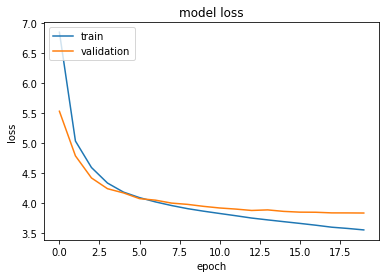

In [20]:
# print(history.history.keys())
# #  "Accuracy"
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
import gc
gc.collect()